## Phenology SIPI

Computes Structure Insensitive Pigment Index (SIPI) which helpful in early disease detection in vegetation.

The focus of this notebook is to analyse information for each pixel based on its focal neighborhood kernel. The xrspatial.focal provides a set of analysis tools performing neighborhood operations and NDVI aggregration.

In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr

import stackstac
import pystac_client

import matplotlib.pyplot as plt

import geopandas as gpd
import json
import rasterio.features
from pystac.extensions.projection import ProjectionExtension as proj

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots

from dask.distributed import Client, progress

### Local Dask Cluster

We'll use a small number of images for this example. We'll parallelize reading the data from Azure Blob Storage using a local Dask "cluster" on this single machine.

In [2]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


You can access the Dask Dashboard by pasting that URL into the Dask labextension field. See [Scale with Dask](../quickstarts/scale-with-dask.ipynb) for more.

### Data

In [3]:
#select country
local =  gpd.read_file('fiji_tavua.geojson')
area_of_interest = local.geometry[0]

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

search = catalog.search(
    intersects=area_of_interest,
    datetime="2016-01-01/2022-03-30",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 10}}, #cloudcover_percentage
)

In [4]:
items = [pc.sign(item).to_dict() for item in search.get_items()]
print(len(items))

60


Now we'll sign the STAC items so we can download the data from blob storage. See [Using Tokens for Data Access](../concepts/sas.ipynb) for more. 

In [5]:
item = next(search.get_items())
epsg = proj.ext(item).epsg

data = (
    stackstac.stack(
        items,
        epsg=epsg,
        resolution=500, #resolution/m
        assets=["B08", "B04", "B02"],  # nir, red, blue
        chunksize=8192, #4096, #256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels 
    )
)

#downsample to monthly
data = data.resample(time="6MS").median("time", keep_attrs=True)
#data = data.resample(time="1Y").median("time", keep_attrs=True)

data

<xarray.DataArray 'stackstac-ba06ae35720df0f3c91db27e5d9b681b' (time: 13, band: 3, y: 221, x: 221)>
dask.array<stack, shape=(13, 3, 221, 221), dtype=float64, chunksize=(1, 1, 221, 221), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2016-01-01...
  * band                                     (band) <U4 'nir' 'red' 'blue'
  * x                                        (x) float64 4.995e+05 ... 6.095e+05
  * y                                        (y) float64 8.100e+06 ... 7.990e+06
    s2:mgrs_tile                             <U5 '60KWF'
    proj:epsg                                int64 32760
    constellation                            <U10 'Sentinel 2'
    s2:product_type                          <U7 'S2MSI2A'
    sat:orbit_state                          <U10 'descending'
    s2:saturated_defective_pixel_percentage  float64 0.0
    s2:datatake_type                         <U8 'INS-NOBS'
    sat:relative_orbit                       int64 72
    instruments                              <U3 'msi'
    gsd                                      int64 10
    proj:bbox                                object {7990240.0, 609780.0, 499...
    proj:transform                           object {0.0, 8100040.0, 10.0, 49...
    proj:shape                               object {10980}
    title                                    (band) <U19 'Band 8 - NIR - 10m'...
    common_name                              (band) <U4 'nir' 'red' 'blue'
    center_wavelength                        (band) float64 0.842 0.665 0.49
    full_width_half_max                      (band) float64 0.145 0.038 0.098
    epsg                                     int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(499500, 7990000, 610000, 8100...
    crs:         epsg:32760
    transform:   | 500.00, 0.00, 499500.00|\n| 0.00,-500.00, 8100500.00|\n| 0...
    resolution:  500

### SIPI - Disease Index

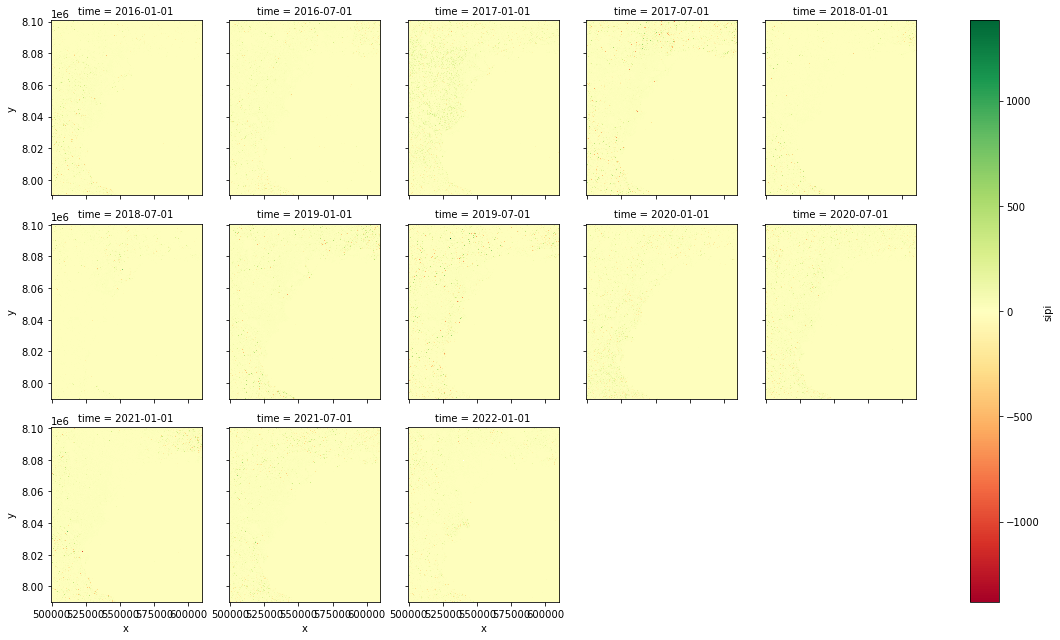

In [6]:
sipi_aggs = [ms.sipi(x.sel(band="nir"), x.sel(band="red"), x.sel(band="blue")) for x in data]

sipi = xr.concat(sipi_aggs, dim="time")

sipi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="RdYlGn"); #RdYlGn #viridis

### Smoothing Images with Focal Mean

[`focal.mean`](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.mean.html) can be used to smooth or reduce noises in an image by a mean reduction to each 3x3 window in an image.

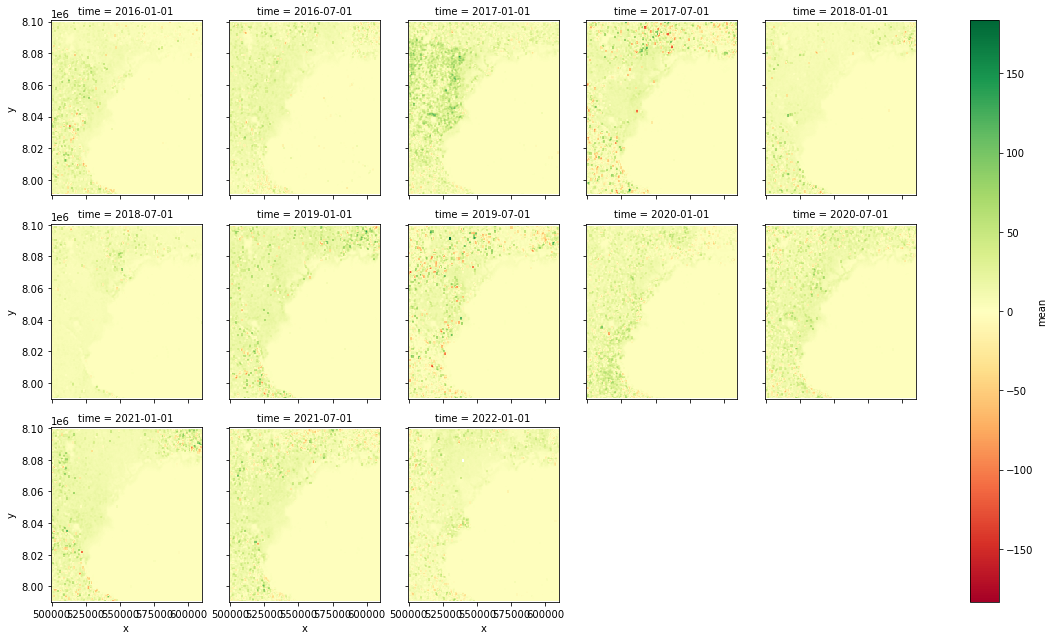

In [7]:
mean_aggs = [mean(sipi_agg) for sipi_agg in sipi_aggs]

smooth = xr.concat(mean_aggs, dim="time")

s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="RdYlGn") #RdYlGn #viridis

In [8]:
type(smooth)

xarray.core.dataarray.DataArray

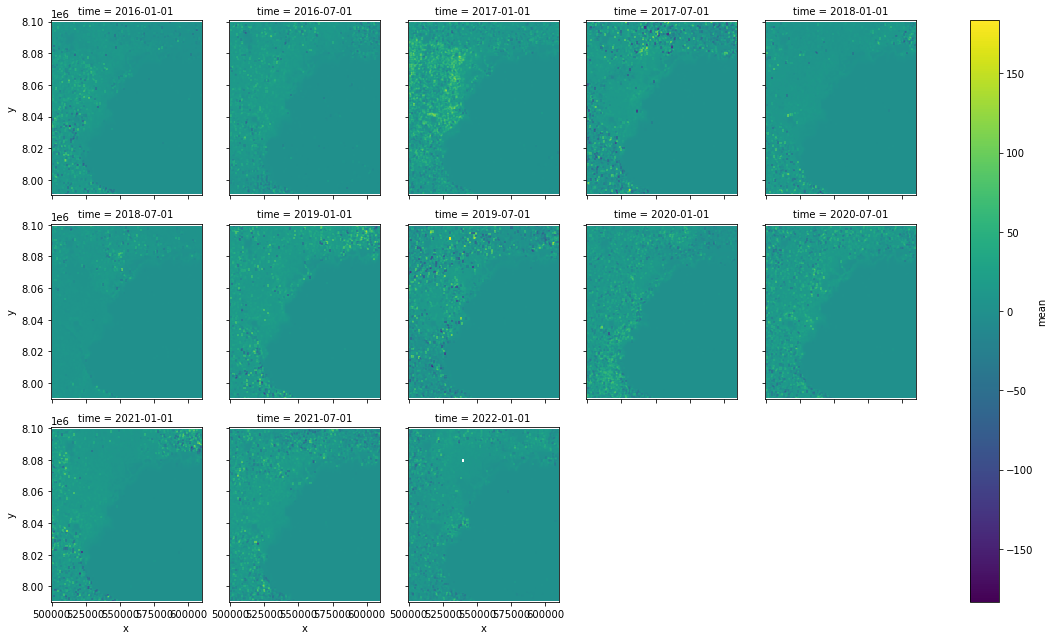

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/srv/

In [9]:
s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis") #RdYlGn #viridis

### Write Out COG tiles and Upload as Azure Blobs
Pending...
